In [1]:
#import data by kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d shashankrapolu/human-action-recognition-dataset

100% 207M/208M [00:10<00:00, 23.8MB/s]
100% 208M/208M [00:10<00:00, 20.9MB/s]


In [3]:
#file unzip
import zipfile
zip_ref = zipfile.ZipFile('/content/human-action-recognition-dataset.zip')
zip_ref.extractall('/content/Data')
zip_ref.close()

In [4]:
!pip install gdown

In [5]:
!gdown  https://drive.google.com/uc?id=1YfVZ7aUefO8Zx5UVnyJg8nIuOLyNcx-Y

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1YfVZ7aUefO8Zx5UVnyJg8nIuOLyNcx-Y 



In [8]:
# Pytorch
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
from torchvision import transforms

# Build up the pretrained transformers model
from transformers import ViTFeatureExtractor, ViTModel

# Plot tool
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

In [9]:
batch_size = 256
latent_dim = 256
epochs = 1
learning_rate = 5e-4

In [10]:
# Add the transformation of image
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.5,)*3, (0.5,)*3)
])

# Path for training and validation dataset
training_path = "/content/Data/Structured/train"
validating_path = "/content/Data/Structured/test"

In [11]:
# Create train, val dataset
training_dataset = ImageFolder(training_path,
                               transform=data_transforms)
validating_dataset = ImageFolder(validating_path,
                                 transform=data_transforms)

# Create train, val dataloader
training_dataloader = DataLoader(training_dataset,
                                 batch_size=batch_size,
                                 shuffle=True)
val_dataloader = DataLoader(validating_dataset,
                            batch_size=batch_size,
                            shuffle=True)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


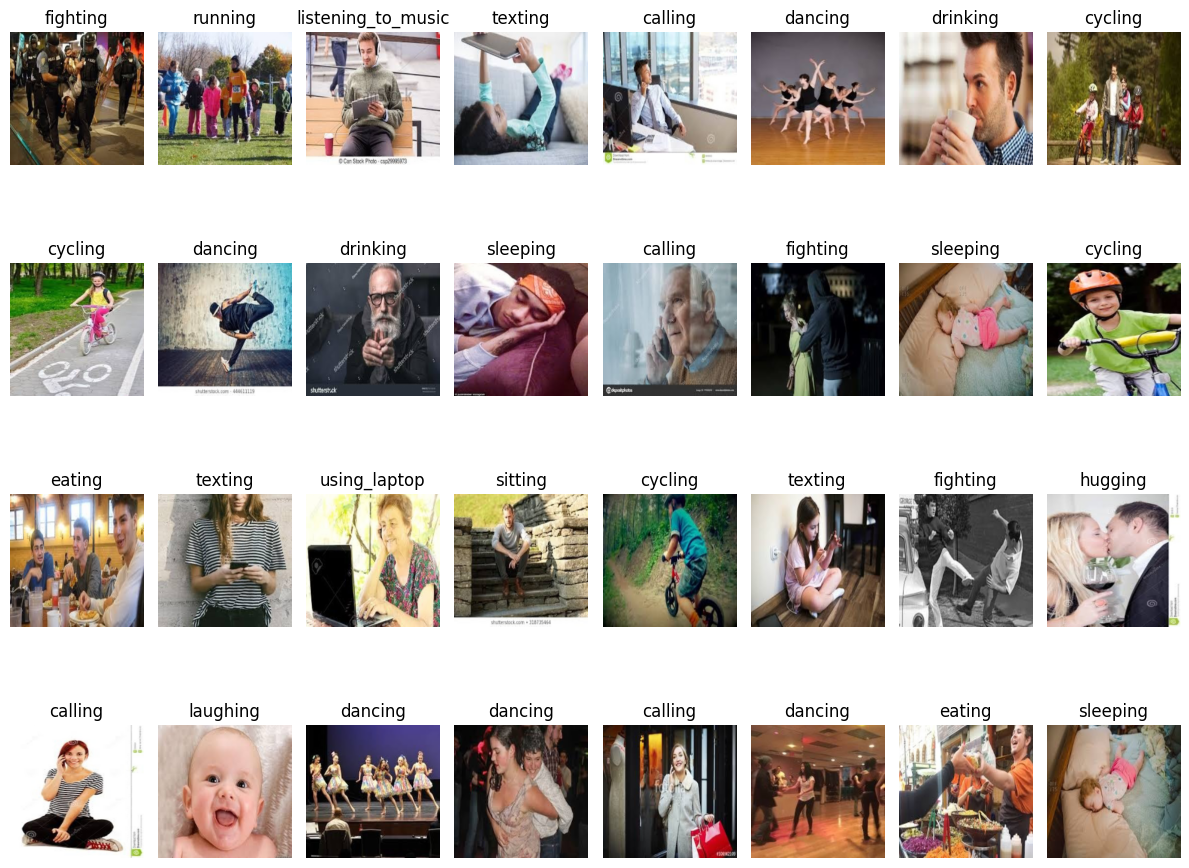

In [12]:
image_size = 32

# Get the image from dataloader
show_images, show_labels = next(iter(training_dataloader))
show_images = show_images[:image_size]
show_labels = show_labels[:image_size]

ncols = 8
nrows = int(image_size / ncols) + 1

# Set up the figure size
plt.figure(figsize=(12, 12))


def inverse_normalized(image):
    # Clamp the value to (0.0, 1.0) for floats
    image = torch.clamp(input=image * 0.5 + 0.5,
                        min=0.0,
                        max=1.0)
    return image


for idx in range(len(show_images)):
    # Set up the subplot
    plt.subplot(nrows, ncols, idx + 1)

    # Close the axis and plot the image
    plt.axis("off")
    # Note that the label is change into integer, we should change it back to category
    plt.title(training_dataset.classes[show_labels[idx].item()])
    # Note that the image channel of tensor is: (channel, width, height)
    # We need to change it to (width, height, channel) which we use permute to realize it
    plt.imshow(inverse_normalized(show_images[idx].permute(1, 2, 0)))

# Avoid overlapping of different titles
plt.tight_layout()

In [13]:
class CategoryClass(nn.Module):
    def __init__(self, vit, latent_dim, classes_):
        super(CategoryClass, self).__init__()

        self.classes_ = classes_

        # Set up model architecture
        self.vit = vit
        self.fc_1 = nn.Linear(768, latent_dim)
        self.fc_out = nn.Linear(latent_dim, self.classes_)
        self.dropout = nn.Dropout(0.2)

    def forward(self, in_data):
        # Type of output `BaseModelOutputWithPooling`
        vit_outputs = self.vit(in_data)

        # Shape of pooler_output: (batch_size, hidden_size)
        pooler_output = vit_outputs.pooler_output

        # Pass through the linear layout to predict the class
        # Shape of output: (batch_size, classes_)
        outputs = torch.relu(self.fc_1(pooler_output))
        outputs = self.fc_out(self.dropout(outputs))

        return outputs

In [14]:
# Set up the pretrained model
vit = ViTModel.from_pretrained('google/vit-base-patch16-224')

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Freeze the layers in vit exclude the pooler layers
for param in vit.parameters():
    param.requires_grad = False

vit.pooler.dense.weight.requires_grad = True
vit.pooler.dense.bias.requires_grad = True

In [17]:
# Create the complete model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CategoryClass(vit,
                      latent_dim,
                      len(training_dataset.classes)).to(device)

In [18]:
# Set up loss function and optimizers
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), learning_rate)

In [19]:
# Save the training and validating information
training_loss_history =[]
training_accuracy_history = []
validating_loss_history = []
validating_accuracy_history = []

# We only train one epoch
#  Therefore, we save the batch information
batch_loss_history = []
batch_accuracy_history = []

for epoch in range(epochs):
    # Set to the train mode
    model.train()

    train_epoch_loss = 0.0
    train_epoch_accuracy = 0.0
    for idx, (images, labels) in enumerate(training_dataloader):
        # Move the data to the device
        images = images.to(device)
        labels = labels.to(device)

        # Pass through the model
        outputs = model(images)

        # Count the loss and update the parameters
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record the training information
        train_epoch_loss += loss.item()
        predict_class = outputs.argmax(dim=-1)
        accuracy = torch.sum(predict_class == labels).item() / labels.shape[0]
        train_epoch_accuracy += accuracy

        # Save the batch information
        batch_loss_history.append(loss.item())
        batch_accuracy_history.append(accuracy)

        # Print batch information
        print(f"Batch {idx + 1} in epoch {epoch + 1}/{epochs}")
        print(f"Average loss: {loss.item()}")
        print(f"Average accuracy {accuracy}")

    # Set to the eval mode
    model.eval()

    val_epoch_loss = 0.0
    val_epoch_accuracy = 0.0

    with torch.no_grad():
        for val_images, val_labels in val_dataloader:
            # Move data to the device
            val_images = val_images.to(device)
            val_labels = val_labels.to(device)

            # Pass through model
            val_outputs = model(val_images)

            # Count the loss and accuracy
            val_epoch_loss += criterion(val_outputs, val_labels)
            val_predict_class = val_outputs.argmax(dim=-1)
            val_epoch_accuracy += torch.sum(val_predict_class == val_labels).item() / val_labels.shape[0]

    # Save the epoch information
    training_loss_history.append(train_epoch_loss / len(training_dataloader))
    training_accuracy_history.append(train_epoch_accuracy / len(training_dataloader))
    validating_loss_history.append(val_epoch_loss / len(val_dataloader))
    validating_accuracy_history.append(val_epoch_accuracy / len(val_dataloader))

    # Print the information
    print(f"Epoch {epoch + 1}")
    print(f"Average training loss: {training_loss_history[-1]}, Average validation loss: {validating_loss_history[-1]}")
    print(f"Average training accuracy: {training_accuracy_history[-1]}, Average validation accuracy: {validating_accuracy_history[-1]}")

Batch 1 in epoch 1/1
Average loss: 2.71761417388916
Average accuracy 0.08203125
Batch 2 in epoch 1/1
Average loss: 2.567534923553467
Average accuracy 0.3515625
Batch 3 in epoch 1/1
Average loss: 2.4182426929473877
Average accuracy 0.5234375
Batch 4 in epoch 1/1
Average loss: 2.310408353805542
Average accuracy 0.5390625
Batch 5 in epoch 1/1
Average loss: 2.145397901535034
Average accuracy 0.609375
Batch 6 in epoch 1/1
Average loss: 1.998776912689209
Average accuracy 0.640625
Batch 7 in epoch 1/1
Average loss: 1.8772392272949219
Average accuracy 0.625
Batch 8 in epoch 1/1
Average loss: 1.6965450048446655
Average accuracy 0.66796875
Batch 9 in epoch 1/1
Average loss: 1.5767136812210083
Average accuracy 0.70703125
Batch 10 in epoch 1/1
Average loss: 1.415407657623291
Average accuracy 0.75390625
Batch 11 in epoch 1/1
Average loss: 1.3191975355148315
Average accuracy 0.73828125
Batch 12 in epoch 1/1
Average loss: 1.2035932540893555
Average accuracy 0.734375
Batch 13 in epoch 1/1
Average loss

In [20]:
# Save the model weight
torch.save(model.state_dict(), "model.pt")

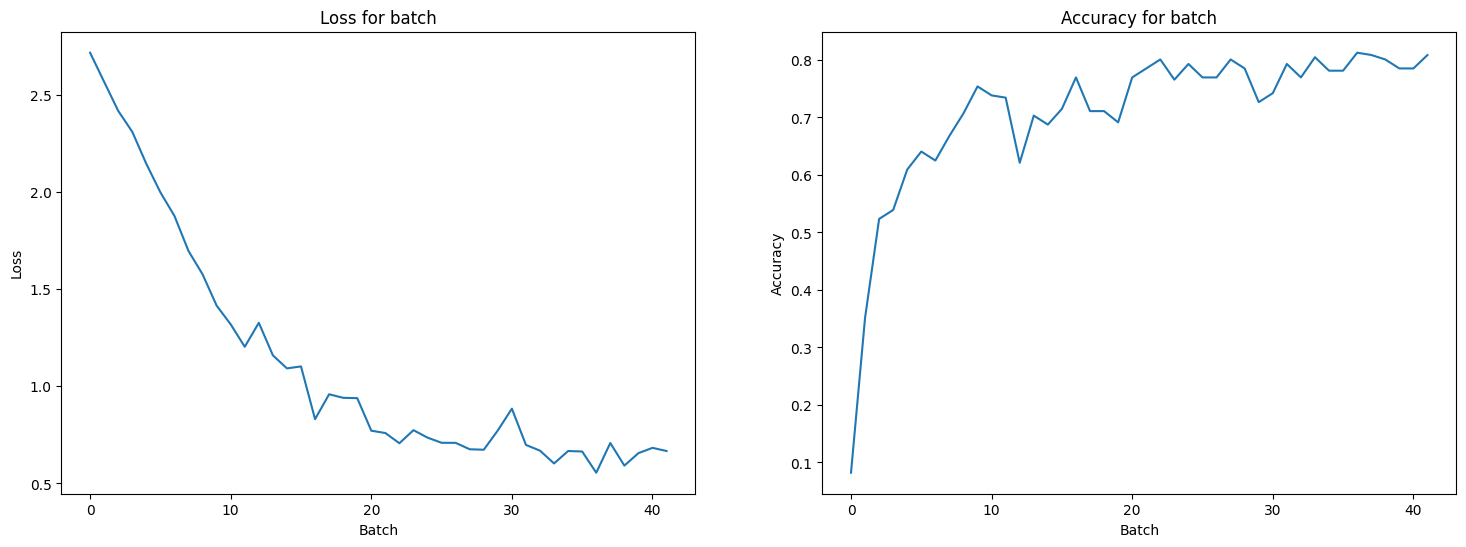

In [21]:
# Plot the loss and accuracy
plt.figure(figsize=(18,6))

# Loss
plt.subplot(1, 2, 1)
plt.title("Loss for batch")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(batch_loss_history)

# Accuracy
plt.subplot(1, 2, 2)
plt.title("Accuracy for batch")
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.plot(batch_accuracy_history)

In [22]:
prediction = []
true_labels = []

# Create the classification report on test dataset
with torch.no_grad():
    for val_images, val_labels in val_dataloader:
        # Move data to the device
        val_images = val_images.to(device)
        val_labels = val_labels.to(device)

        # Pass through model
        val_outputs = model(val_images)

        # Count the loss and accuracy
        val_predict_class = val_outputs.argmax(dim=-1)

        prediction.extend([predict_class.item() for predict_class in val_predict_class])
        true_labels.extend([val_label.item() for val_label in val_labels])

In [23]:
import pandas as pd

# Output dict for making the report
report = classification_report(true_labels, prediction,
                               output_dict=True,
                               target_names=training_dataset.classes)
report_df = pd.DataFrame(report).transpose()

In [24]:
# Show all columns
pd.set_option("display.max_rows", None)
report_df.head(134)

,precision,recall,f1-score,support
calling,0.671053,0.809524,0.733813,126.00000
clapping,0.839623,0.706349,0.767241,126.00000
cycling,0.969231,1.000000,0.984375,126.00000
dancing,0.868217,0.888889,0.878431,126.00000
drinking,0.862319,0.944444,0.901515,126.00000
eating,0.902985,0.960317,0.930769,126.00000
fighting,0.886957,0.809524,0.846473,126.00000
hugging,0.823077,0.849206,0.835938,126.00000
laughing,0.782258,0.769841,0.776000,126.00000
listening_to_music,0.680328,0.658730,0.669355,126.00000
